In [1]:
!pip install pandas matplotlib seaborn tensorflow Pillow scikit-learn pyswarm


In [2]:
import numpy as np
import pandas as pd 
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import sys
import time
import tensorflow.keras as keras
import tensorflow as tf
import re
from pyswarm import pso

from PIL import Image
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.models import Model, Sequential

from keras.utils import to_categorical
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image


from tensorflow.keras.preprocessing import image

In [3]:
import tensorflow as tf
from tensorflow.config import list_physical_devices

# Verificar se há GPUs disponíveis
print("Verificando GPUs disponíveis...")
gpus = list_physical_devices('GPU')
if gpus:
    try:
        # Configuração de crescimento de memória (opcional, mas recomendado)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs configuradas: {gpus}")
    except RuntimeError as e:
        print(f"Erro ao configurar GPUs: {e}")
else:
    print("Nenhuma GPU detectada. Usando CPU.")


Verificando GPUs disponíveis...
Nenhuma GPU detectada. Usando CPU.


In [4]:
# Definir o tamanho das imagens 
IMAGE_WIDTH = 224    
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


# Caminho das imagens
base_path = "C:/Users/joaom/Documents/GitHub/Trabalho-IC/archive/garbage_classification/"

# augmented_dir = "C:/Users/joaom/Documents/GitHub/Trabalho-SO/archive/garbage_classification/augmentation/"


# 4 classes
categories = {0: 'biological', 1: 'clothes', 2: 'shoes', 3: 'trash'}

In [5]:
# Função que tranforma isto "/paper104.jpg" em isto "paper/paper104.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search(r"\d", x).start()] + '/' + x)


    return df

# Lista com os filenames do dataset
filenames_list = []

# Lista para guardar as categorias
categories_list = []

# Preenche as listas
# Corrige a construção do caminho
for category in categories:
    filenames = os.listdir(os.path.join(base_path, categories[category]))
    
    filenames_list = filenames_list + filenames
    categories_list = categories_list + [category] * len(filenames)

# Atribui ao dataframe os valores
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

# Chama a função para adicionar o nome na directoria
df = add_class_name_prefix(df, 'filename')

# Baralha o dataframe
df = df.sample(frac=1).reset_index(drop=True)




print('Número total de imagens do Dataset = ' , len(df))

Número total de imagens do Dataset =  9988


In [6]:
# Mostra as 5 primeiras
df.head()

,filename,category
0,shoes/shoes974.jpg,2
1,clothes/clothes1777.jpg,1
2,trash/trash1058.jpg,3
3,trash/trash1297.jpg,3
4,clothes/clothes402.jpg,1


trash/trash532.jpg


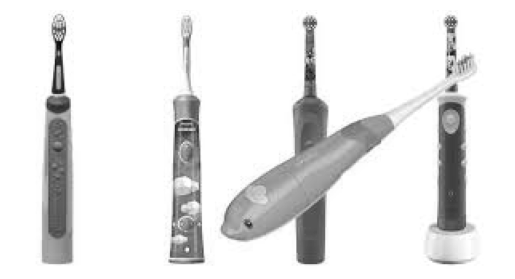

In [7]:
# Seleciona uma linha aleatória
random_row = random.randint(0, len(df) - 1)

sample = df.iloc[random_row]

# Carrega a imagem em escala de cinza
randomimage = image.load_img(os.path.join(base_path, sample['filename']), color_mode='grayscale')

# Exibe o nome do arquivo e a imagem
print(sample['filename'])
plt.imshow(randomimage, cmap='gray')
plt.axis('off')  #Não ter eixos para ser mais facil perceber a imagem
plt.show()  #  Mostra a imagem

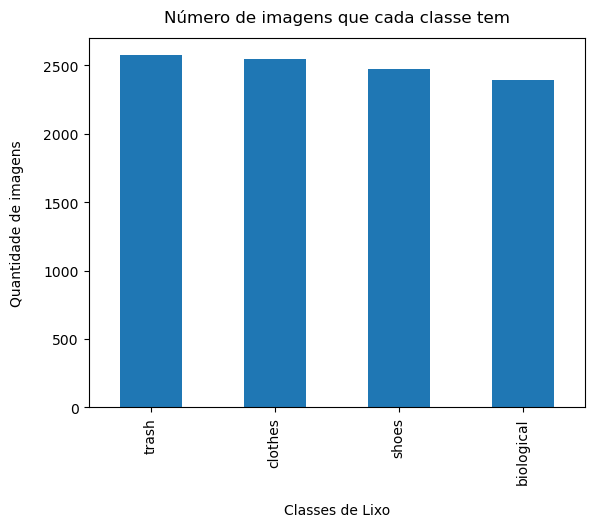

In [8]:
# Mostra quantas imagens cada classe tem. Dá jeito para confirmar que as imagens estão a ser todas reconhecidas
df_visualization = df.copy()

df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Classes de Lixo", labelpad=14)
plt.ylabel("Quantidade de imagens", labelpad=14)
plt.title("Número de imagens que cada classe tem", y=1.02);

In [9]:
# Muda as categorias de numeros para nome
df["category"] = df["category"].replace(categories) 

# Dividimos o nosso dataset em treino, validação e teste, de modo a ter dados mais fidedignos e não
# tão tendenciosos. 80% para treino, 10% para validação e 10% para teste
# Ao dividir em validação permite-nos ver se o modelo está em overfitting, gera-nos outros dados que não
# os de treino





# Dividir o dataset em 80% treino/validação e 20% teste
train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df['category'], random_state=42)

# Dividir os 80% em treino (70%) e validação (10%)
train_df, validate_df = train_test_split(train_val_df, test_size=0.25, stratify=train_val_df['category'], random_state=42)

# Resetar índices
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


total_train = train_df.shape[0] 
total_validate = validate_df.shape[0] 

# Verificar as proporções
print('Num Imagens de Treino =', len(train_df),
      ' Num Imagens de Validação =', len(validate_df),
      ' Num Imagens de Teste =', len(test_df))


from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size=32
# Gerador de aumento de dados para o treino
train_datagen = ImageDataGenerator(
    rotation_range=30,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1.0/255  # Normalizar os valores de pixel para [0, 1]
)

# Gerador para validação (sem aumento de dados)
validation_datagen = ImageDataGenerator(rescale=1.0/255)

# Criar geradores de treino e validação
train_generator = train_datagen.flow_from_dataframe(
    train_df,  # DataFrame de treino
    directory=base_path,  # Caminho das imagens
    x_col='filename',  # Coluna com os caminhos das imagens
    y_col='category',  # Coluna com os rótulos
    target_size=IMAGE_SIZE,  # Tamanho das imagens (ex.: (224, 224))
    class_mode='categorical',  # Rótulos no formato one-hot
    batch_size=batch_size  # Tamanho do lote
)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,  # DataFrame de validação
    directory=base_path,  # Caminho das imagens
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

# Variáveis úteis
steps_per_epoch = len(train_df) // batch_size  # Número de lotes por época
total_validate = len(validate_df)

# Criar subconjuntos para otimização
train_subset = train_df.sample(frac=0.2, random_state=42)  # Usar 20% do treino
validate_subset = validate_df.sample(frac=0.1, random_state=42)  # Usar 10% da validação

# Criar novos geradores baseados nos subconjuntos
train_generator_subset = train_datagen.flow_from_dataframe(
    train_subset,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

validation_generator_subset = validation_datagen.flow_from_dataframe(
    validate_subset,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)


Num Imagens de Treino = 5992  Num Imagens de Validação = 1998  Num Imagens de Teste = 1998
Found 5992 validated image filenames belonging to 4 classes.
Found 1998 validated image filenames belonging to 4 classes.
Found 1198 validated image filenames belonging to 4 classes.
Found 200 validated image filenames belonging to 4 classes.


In [10]:
class fwa:
    """
    Firework Algorithm (FWA)
    """
    def __init__(self, n, function, lb, ub, dimension, iteration, m1=2, m2=2, eps=0.001, amp=2, a=0.2, b=2):
        self.__agents = np.random.uniform(lb, ub, (n, dimension))
        self._points = [self.__agents]

        fitness = np.array([function(agent) for agent in self.__agents])
        Pbest = self.__agents[fitness.argmin()]
        Gbest = Pbest

        for _ in range(iteration):
            Ymin = fitness.min()
            Ymax = fitness.max()
            sparks = []

            for i, fw in enumerate(self.__agents):
                self.__explosion_operator(sparks, fw, fitness[i], Ymin, Ymax, function, m1, eps, amp, a, b)
                self.__gaussian_mutation(sparks, fw, m2)

            sparks = np.array(sparks)
            self.__mapping_rule(sparks, lb, ub, dimension)

            # Avaliar todos os sparks
            all_agents = np.vstack((self.__agents, sparks))
            all_fitness = np.array([function(agent) for agent in all_agents])

            # Selecionar os melhores agentes
            best_indices = np.argsort(all_fitness)[:n]
            self.__agents = all_agents[best_indices]
            fitness = all_fitness[best_indices]

            # Atualizar Gbest
            Pbest = self.__agents[fitness.argmin()]
            if function(Pbest) < function(Gbest):
                Gbest = Pbest

        self.Gbest = Gbest
        self.Gbest_value = function(Gbest)

    def __explosion_operator(self, sparks, fw, fitness_fw, Ymin, Ymax, function, m, eps, amp, a, b):
        sparks_num = self.__round(
            m * (Ymax - fitness_fw + eps) /
            (np.sum([Ymax - function(agent) for agent in self.__agents]) + eps),
            m, a, b
        )

        amplitude = amp * (fitness_fw - Ymin + eps) / \
                    (np.sum([function(agent) - Ymin for agent in self.__agents]) + eps)

        for _ in range(int(sparks_num)):
            spark = fw + np.random.uniform(-amplitude, amplitude, len(fw))
            sparks.append(spark)

    def __gaussian_mutation(self, sparks, fw, m):
        for _ in range(m):
            g = np.random.normal(1, 1)
            spark = fw * g
            sparks.append(spark)

    def __mapping_rule(self, sparks, lb, ub, dimension):
        lb = np.array(lb)
        ub = np.array(ub)
        for i in range(len(sparks)):
            sparks[i] = np.clip(sparks[i], lb, ub)

    def __selection(self, sparks, n, function):
        self.__agents = sorted(np.concatenate((self.__agents, sparks)), key=function)[:n]

    def __round(self, s, m, a, b):
        if s < a * m:
            return round(a * m)
        elif s > b * m:
            return round(b * m)
        else:
            return round(s)



In [11]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, MaxPooling2D, Conv2D, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

num_classes = df['category'].nunique()  # Número de classes

def objective_function(params):
    # Hiperparâmetros
    lr, neurons = params
    neurons = int(neurons)

    # Base MobileNetV2
    mobilenetv2_layer = MobileNetV2(
        include_top=False,
        input_shape=(224, 224, 3),
        weights='imagenet'
    )
    mobilenetv2_layer.trainable = False  # Congelar a base

    # Construir o modelo
    model = Sequential()
    model.add(mobilenetv2_layer)
    model.add(Conv2D(8, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    model.add(Flatten())
    model.add(Dense(neurons, kernel_regularizer=l2(0.001)))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Dense(num_classes, activation='softmax'))

    # Compilar o modelo
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
   

    # Configurar Early Stopping
    early_stopping = EarlyStopping(
        monitor='val_categorical_accuracy',
        patience=2,
        restore_best_weights=True,
        verbose=0
    )

    # Treinar o modelo
    history = model.fit(
        train_generator_subset,
        validation_data=validation_generator_subset,
        epochs=5,  # Número de épocas
        steps_per_epoch=len(train_subset) // batch_size,
        validation_steps=len(validate_subset) // batch_size,
        verbose=1,
        callbacks=[early_stopping]
    )

    # Retornar a acurácia de validação (negativa para o PSO)
    val_accuracy = history.history['val_categorical_accuracy'][-1]
    return -val_accuracy




In [12]:
num_classes = df['category'].nunique()
print("Número de classes:", num_classes)

Número de classes: 4


In [13]:
# Limites de busca ajustados
#lb = [1e-4, 50]  
#ub = [1e-3, 200]  

# Parâmetros do algoritmo ajustados
#n_agents = 3        # Número de agentes 
#dimension = 2       # Número de parâmetros a otimizar (lr, neurons)
#iterations = 5     # Número de iterações 

# Chamada ao FWA com menos sparks
#fwa_optimizer = fwa(
#    n=n_agents,
#    function=objective_function,
#    lb=lb,
#    ub=ub,
#    dimension=dimension,
#    iteration=iterations,
#    m1=2,  # Sparks normais
#    m2=2   # Sparks gaussianos 
#)

# Resultados
#best_params = fwa_optimizer.Gbest  # Melhor combinação de hiperparâmetros
#best_score = -fwa_optimizer.Gbest_value  # Melhor accuracy de validação (positivo)

#print(f"Melhores parâmetros encontrados: {best_params}")
#print(f"Acurácia de validação correspondente: {best_score}")



In [14]:
import random
import openpyxl

# Criar um novo workbook
workbook = openpyxl.Workbook()
sheet = workbook.active
sheet.title = "Random Search Results"

# Cabeçalhos para o Excel
sheet.append(["Learning Rate", "Neurons", "Accuracy"])

# Lista para armazenar resultados
random_search_results = []  # Corrige o erro adicionando esta lista

# Número de amostras para o Random Search
n_samples = 5  # Defina quantas combinações você deseja avaliar

# Executar o Random Search
for _ in range(n_samples):
    # Gerar hiperparâmetros aleatórios dentro dos limites
    lr = random.uniform(1e-4, 1e-2)  # Taxa de aprendizado aleatória
    neurons = random.randint(50, 250)  # Número de neurônios aleatório

    # Avaliar o modelo com a função objetivo
    score = objective_function([lr, neurons])

    # Salvar os resultados na lista
    random_search_results.append((lr, neurons, -score))  # Acurácia positiva para facilitar a interpretação

    # Salvar os resultados no Excel
    sheet.append([lr, neurons, -score])

# Melhor resultado do Random Search
best_random = max(random_search_results, key=lambda x: x[2])  # Ordenar por acurácia
print(f"Melhores parâmetros pelo Random Search: lr={best_random[0]}, neurons={best_random[1]}")
print(f"Acurácia correspondente: {best_random[2]}")

# Salvar o arquivo Excel
workbook.save("random_search_results.xlsx")



C:\Users\joaom\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 600ms/step - categorical_accuracy: 0.7074 - loss: 0.8660 - val_categorical_accuracy: 0.9479 - val_loss: 0.2491
Epoch 2/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - categorical_accuracy: 0.9062 - loss: 0.4168 - val_categorical_accuracy: 0.8750 - val_loss: 0.5140
Epoch 3/5


C:\Users\joaom\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 569ms/step - categorical_accuracy: 0.9416 - loss: 0.3048 - val_categorical_accuracy: 0.9323 - val_loss: 0.3333
Epoch 1/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 588ms/step - categorical_accuracy: 0.7694 - loss: 0.7332 - val_categorical_accuracy: 0.9688 - val_loss: 0.2383
Epoch 2/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - categorical_accuracy: 1.0000 - loss: 0.1322 - val_categorical_accuracy: 1.0000 - val_loss: 0.0877
Epoch 3/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 558ms/step - categorical_accuracy: 0.9415 - loss: 0.2548 - val_categorical_accuracy: 0.9583 - val_loss: 0.2250
Epoch 4/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9375 - loss: 0.3937 - val_categorical_accuracy: 1.0000 - val_loss: 0.1174
Epoch 1/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 611ms/step - categorical_accuracy: 0.5778 - loss: 1.0768 - val_categorical_accuracy: 0.9375 - val_loss: 0.4577
Epoch 2/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - categorical_accuracy: 1.0000 - loss: 0.1525 - val_cat

In [15]:
import openpyxl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Abrir o arquivo Excel
workbook = openpyxl.load_workbook("random_search_results.xlsx")
sheet = workbook.active

# Ler os dados do Excel
learning_rates = []
neurons = []
accuracies = []

for row in sheet.iter_rows(min_row=2, values_only=True):  # Ignorar cabeçalhos
    learning_rates.append(row[0])
    neurons.append(row[1])
    accuracies.append(row[2])


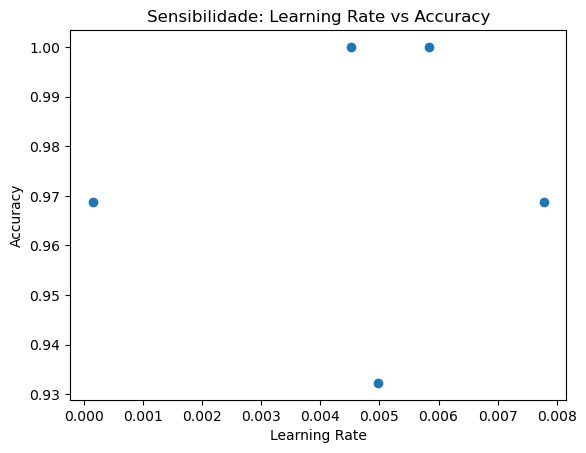

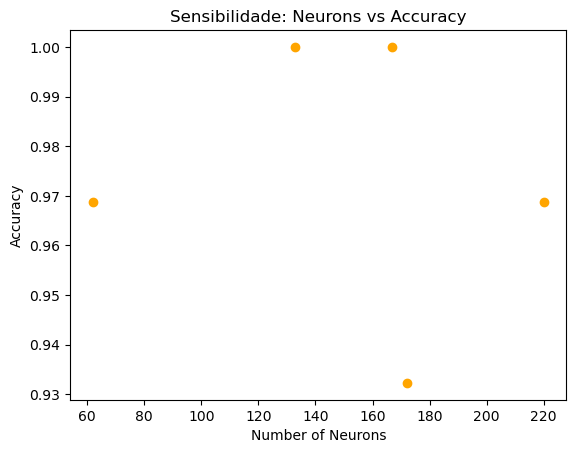

In [16]:
# Gráfico da taxa de aprendizado vs acurácia
plt.scatter(learning_rates, accuracies, label="Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("Sensibilidade: Learning Rate vs Accuracy")
plt.show()

# Gráfico do número de neurônios vs acurácia
plt.scatter(neurons, accuracies, color='orange', label="Neurons")
plt.xlabel("Number of Neurons")
plt.ylabel("Accuracy")
plt.title("Sensibilidade: Neurons vs Accuracy")
plt.show()

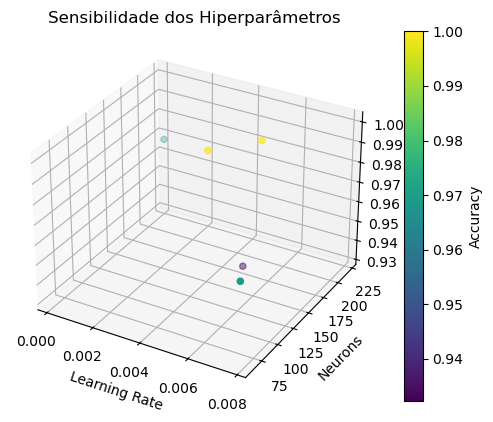

In [17]:
# Gráfico 3D: Taxa de aprendizado, neurônios e acurácia
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(learning_rates, neurons, accuracies, c=accuracies, cmap='viridis')

# Adicionar rótulos aos eixos
ax.set_xlabel("Learning Rate")
ax.set_ylabel("Neurons")
ax.set_zlabel("Accuracy")
plt.title("Sensibilidade dos Hiperparâmetros")

# Adicionar uma barra de cores
cbar = plt.colorbar(scatter)
cbar.set_label("Accuracy")
plt.show()


In [18]:
# Comparação dos Resultados
#print("=== Comparação dos Resultados ===")
#print(f"Melhores parâmetros pelo FWA: lr={best_params[0]}, neurons={best_params[1]}")
#print(f"Acurácia de validação pelo FWA: {best_score}")
#print()
print(f"Melhores parâmetros pelo Random Search: lr={best_random[0]}, neurons={best_random[1]}")
print(f"Acurácia de validação pelo Random Search: {best_random[2]}")


Melhores parâmetros pelo Random Search: lr=0.004525371300736629, neurons=133
Acurácia de validação pelo Random Search: 1.0


In [19]:
#import matplotlib.pyplot as plt

# Resultados do FWA e Random Search
#fwa_accuracy = best_score
#random_accuracies = [result[2] for result in random_search_results]

# Plotar Comparação
#plt.bar(["FWA"], [fwa_accuracy], color="blue", label="FWA")
#plt.bar(["Random Search"] * len(random_accuracies), random_accuracies, color="orange", alpha=0.7, label="Random Search")
#plt.ylabel("Acurácia de Validação")
#plt.title("Comparação: FWA vs Random Search")
#plt.legend()
#plt.show()


In [20]:
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2

lr = best_random[0]        # Taxa de aprendizado
neurons = best_random[1]   # Número de neurônios


# Hiperparâmetros
num_classes = 4
input_shape = (224, 224, 3)

# Base MobileNetV2
mobilenetv2_layer = MobileNetV2(
    include_top=False,
    input_shape=input_shape,
    weights='imagenet'
)
mobilenetv2_layer.trainable = False  # Congelar a base

# Construção do modelo
model = Sequential()
model.add(mobilenetv2_layer)  # Base MobileNetV2

# Bloco convolucional adicional
model.add(Conv2D(8, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# Camadas densas
model.add(Flatten())
model.add(Dense(neurons, kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(num_classes, activation='softmax'))

# Compilar o modelo
model.compile(
    optimizer=Adam(learning_rate=lr),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

# Resumo do modelo
model.summary()



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 8)        │        92,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 7, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 7, 7, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 3, 3, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 72)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 133)            │         9,709 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 133)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 133)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           536 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,360,429 (9.00 MB)

 Trainable params: 102,429 (400.11 KB)

 Non-trainable params: 2,258,000 (8.61 MB)

In [21]:
early_stop = EarlyStopping(patience = 2, verbose = 1, monitor='val_categorical_accuracy' , mode='max', min_delta=0.001, restore_best_weights = True)

callbacks = [early_stop]



In [22]:
# Muda as categorias de numeros para nome
df["category"] = df["category"].replace(categories) 

# Dividimos o nosso dataset em treino, validação e teste, de modo a ter dados mais fidedignos e não
# tão tendenciosos. 80% para treino, 10% para validação e 10% para teste
# Ao dividir em validação permite-nos ver se o modelo está em overfitting, gera-nos outros dados que não
# os de treino



# Dividir o dataset em 80% treino/validação e 20% teste
train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df['category'], random_state=42)

# Dividir os 80% em treino (70%) e validação (10%)
train_df, validate_df = train_test_split(train_val_df, test_size=0.25, stratify=train_val_df['category'], random_state=42)


train_df = train_df.reset_index(drop=True) 
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0] 
total_validate = validate_df.shape[0] 

print('Num Imagens de Treino = ', total_train , '  Num Imagens de Validação = ', total_validate, '  Num Imagens de Teste = ', test_df.shape[0])

Num Imagens de Treino =  5992   Num Imagens de Validação =  1998   Num Imagens de Teste =  1998


In [23]:
batch_size=64

train_datagen = image.ImageDataGenerator(
    
    ###  Augmentation Start  ###
    
    rotation_range=30,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2
    
    ##  Augmentation End  ###
)



train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)
steps_per_epoch = len(train_df) // batch_size  # Número de batches
total_steps = steps_per_epoch * batch_size 


print(f"Total training samples: {len(train_df)}")
print(f"Total de exemplos processados por época: {total_steps}")

Found 5992 validated image filenames belonging to 4 classes.
Total training samples: 5992
Total de exemplos processados por época: 5952


In [24]:
validation_datagen = image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1998 validated image filenames belonging to 4 classes.


In [25]:
EPOCHS = 20
history = model.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)




C:\Users\joaom\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - categorical_accuracy: 0.5799 - loss: 1.0813 - val_categorical_accuracy: 0.7364 - val_loss: 0.7806
Epoch 2/20
 1/93 ━━━━━━━━━━━━━━━━━━━━ 1:07 735ms/step - categorical_accuracy: 0.7500 - loss: 0.5866

C:\Users\joaom\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - categorical_accuracy: 0.7500 - loss: 0.5866 - val_categorical_accuracy: 0.7143 - val_loss: 0.8555
Epoch 3/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - categorical_accuracy: 0.7649 - loss: 0.6822 - val_categorical_accuracy: 0.8311 - val_loss: 0.5152
Epoch 4/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.8750 - loss: 0.4234 - val_categorical_accuracy: 0.7143 - val_loss: 0.6197
Epoch 5/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - categorical_accuracy: 0.7844 - loss: 0.6053 - val_categorical_accuracy: 0.8342 - val_loss: 0.4769
Epoch 6/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.8125 - loss: 0.6579 - val_categorical_accuracy: 0.9286 - val_loss: 0.3346
Epoch 7/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - categorical_accuracy: 0.7966 - loss: 0.5680 - val_categorical_accuracy: 0.8211 - val_loss: 0.5252
Epoch 8/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.7969 - loss: 0.4826 - val_catego

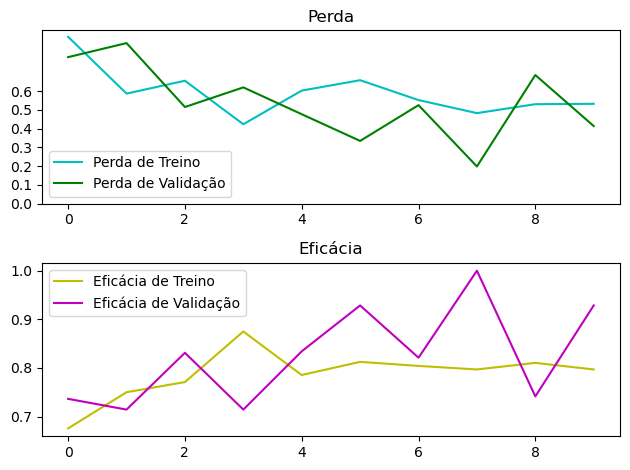

In [26]:
from tensorflow.keras.models import load_model
model.save("meu_modelo.keras")

import matplotlib.pyplot as plt
import numpy as np

# Criar os gráficos de perda e acurácia
fig, (ax1, ax2) = plt.subplots(2, 1)

# Gráfico de perda
ax1.plot(history.history['loss'], color='c', label="Perda de Treino")
ax1.plot(history.history['val_loss'], color='g', label="Perda de Validação")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.set_title("Perda")
ax1.legend()

# Gráfico de eficácia
ax2.plot(history.history['categorical_accuracy'], color='y', label="Eficácia de Treino")
ax2.plot(history.history['val_categorical_accuracy'], color='m', label="Eficácia de Validação")
ax2.set_title("Eficácia")
ax2.legend()

# Ajustar layout
plt.tight_layout()
plt.show()


In [27]:
test_datagen = image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False, 
    drop_remainder=False
)


valid_filenames = set(test_generator.filenames)  # Obter os nomes válidos do gerador
test_df = test_df[test_df['filename'].isin(valid_filenames)]  # Filtrar dataframe

Found 1998 validated image filenames belonging to 4 classes.


In [28]:
filenames = test_generator.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate(test_generator, steps=nb_samples)

print('Eficácia de teste = ',  round((accuracy * 100),2 ), '% ') 

   8/1998 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - categorical_accuracy: 1.0000 - loss: 0.2560

C:\Users\joaom\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1998/1998 ━━━━━━━━━━━━━━━━━━━━ 29s 14ms/step - categorical_accuracy: 0.8389 - loss: 0.4618
Eficácia de teste =  82.93 % 


In [29]:
# No inicio definimos as nossas proprias classes, no entanto, o gerador de treino gera as suas proprias
# Logo estas têm diferentes números para as nossas categorias/classes
# As previsões serão feitas com base no numero das classes do gerador

gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

{0: 'biological', 1: 'clothes', 2: 'shoes', 3: 'trash'}


1998/1998 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step
              precision    recall  f1-score   support

  biological       0.84      0.79      0.81       479
     clothes       0.74      0.94      0.83       510
       shoes       0.81      0.76      0.78       494
       trash       0.98      0.83      0.90       515

    accuracy                           0.83      1998
   macro avg       0.84      0.83      0.83      1998
weighted avg       0.84      0.83      0.83      1998



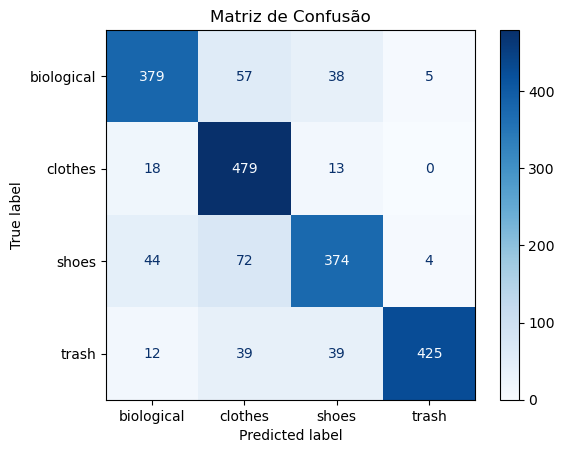

In [30]:
# Mete na previsão do modelo os nossos dados de teste
#preds = model.predict(test_generator, steps=len(test_generator))

steps = int(np.ceil(len(test_df) / test_generator.batch_size))  # Garantir que todos os dados sejam processados
preds = model.predict(test_generator, steps=steps)


# Vais buscar o NUMERO da categoria com a probabilidade de previsão mais alta
preds_classes = preds.argmax(axis=1)  # Armazenar as classes previstas como índices

# Converter índices para nomes das classes usando o dicionário
preds_labels = [gen_label_map[item] for item in preds_classes]  # Mapeia índices para nomes

# Converte o dataframe para uma matriz
labels = test_df['category'].to_numpy()  # Assume que isso é uma lista de strings

# Exibe o relatório de classificação
print(classification_report(labels, preds_labels))

# Criar a matriz de confusão
cm = confusion_matrix(labels, preds_labels)  

# Exibir a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gen_label_map.values())
disp.plot(cmap=plt.cm.Blues)  
plt.title('Matriz de Confusão')
plt.show()
